In [1]:
import os
import shutil

from diffusers import DiffusionPipeline
import torch
from PIL import Image
import numpy as np
from RealESRGAN import RealESRGAN
from tqdm.notebook import tqdm


model_id = "yahoo-inc/photo-background-generation"
pipeline = DiffusionPipeline.from_pretrained(model_id, custom_pipeline=model_id)
device = torch.device("cuda:0")


pipeline = pipeline.to(device)


upscaler = RealESRGAN(device, scale=4)
upscaler.load_weights('weights/RealESRGAN_x4.pth', download=True)


/home/jupyter-kazancev.danil7@wb-2ede4/anaconda3/envs/anti_spam/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
# !pip install transparent_background

In [3]:
from PIL import Image, ImageOps
import requests
from io import BytesIO
from transparent_background import Remover

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

seed = 0
orig_img = Image.open("test_imgs/village_sofa.webp")

resized_img = resize_with_padding(orig_img, (512, 512))

# Load background detection model
remover = Remover(mode='fast', device='cuda:0', ckpt='weights/ckpt_fast.pth') # default setting
# remover = Remover(mode='base') # nightly release checkpoint

# Get foreground mask
fg_mask = remover.process(resized_img, type='map') # default setting - transparent background


/home/jupyter-kazancev.danil7@wb-2ede4/anaconda3/envs/anti_spam/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Settings -> Mode=fast, Device=cuda:0, Torchscript=disabled


In [4]:
from lib.clip_classifier import ClipClassfifier
import json

with open('data.json', 'r') as f:
    data = json.load(f)
    
clip_clf = ClipClassfifier(data["furniture_types"])


In [5]:
item_description = clip_clf.describe_image(orig_img)
print(f"Description: {item_description}")

2024-06-11 15:45:50.096 | INFO     | lib.clip_classifier:describe_image:27 - Provided item classified as sofa which must placed outdoor


Description: {'furniture': 'sofa', 'category': 'outdoor'}


In [6]:
import matplotlib.pyplot as plt

def make_plot(img_list, fig_path):
    fig = plt.figure(figsize=(20, 20))
    assert len(img_list) % 10 == 0
    column_num = 5 
    raws_num = len(img_list) // column_num
    for i, img in enumerate(img_list):
        img = img.resize((512, 512))
        ax = fig.add_subplot(4, 5, i + 1)
        ax.set_title(f"img_number_{i + 1}")
        ax.imshow(img)
        ax.axis('off')
        
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.savefig(fig_path)
    
    plt.show()  # 

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

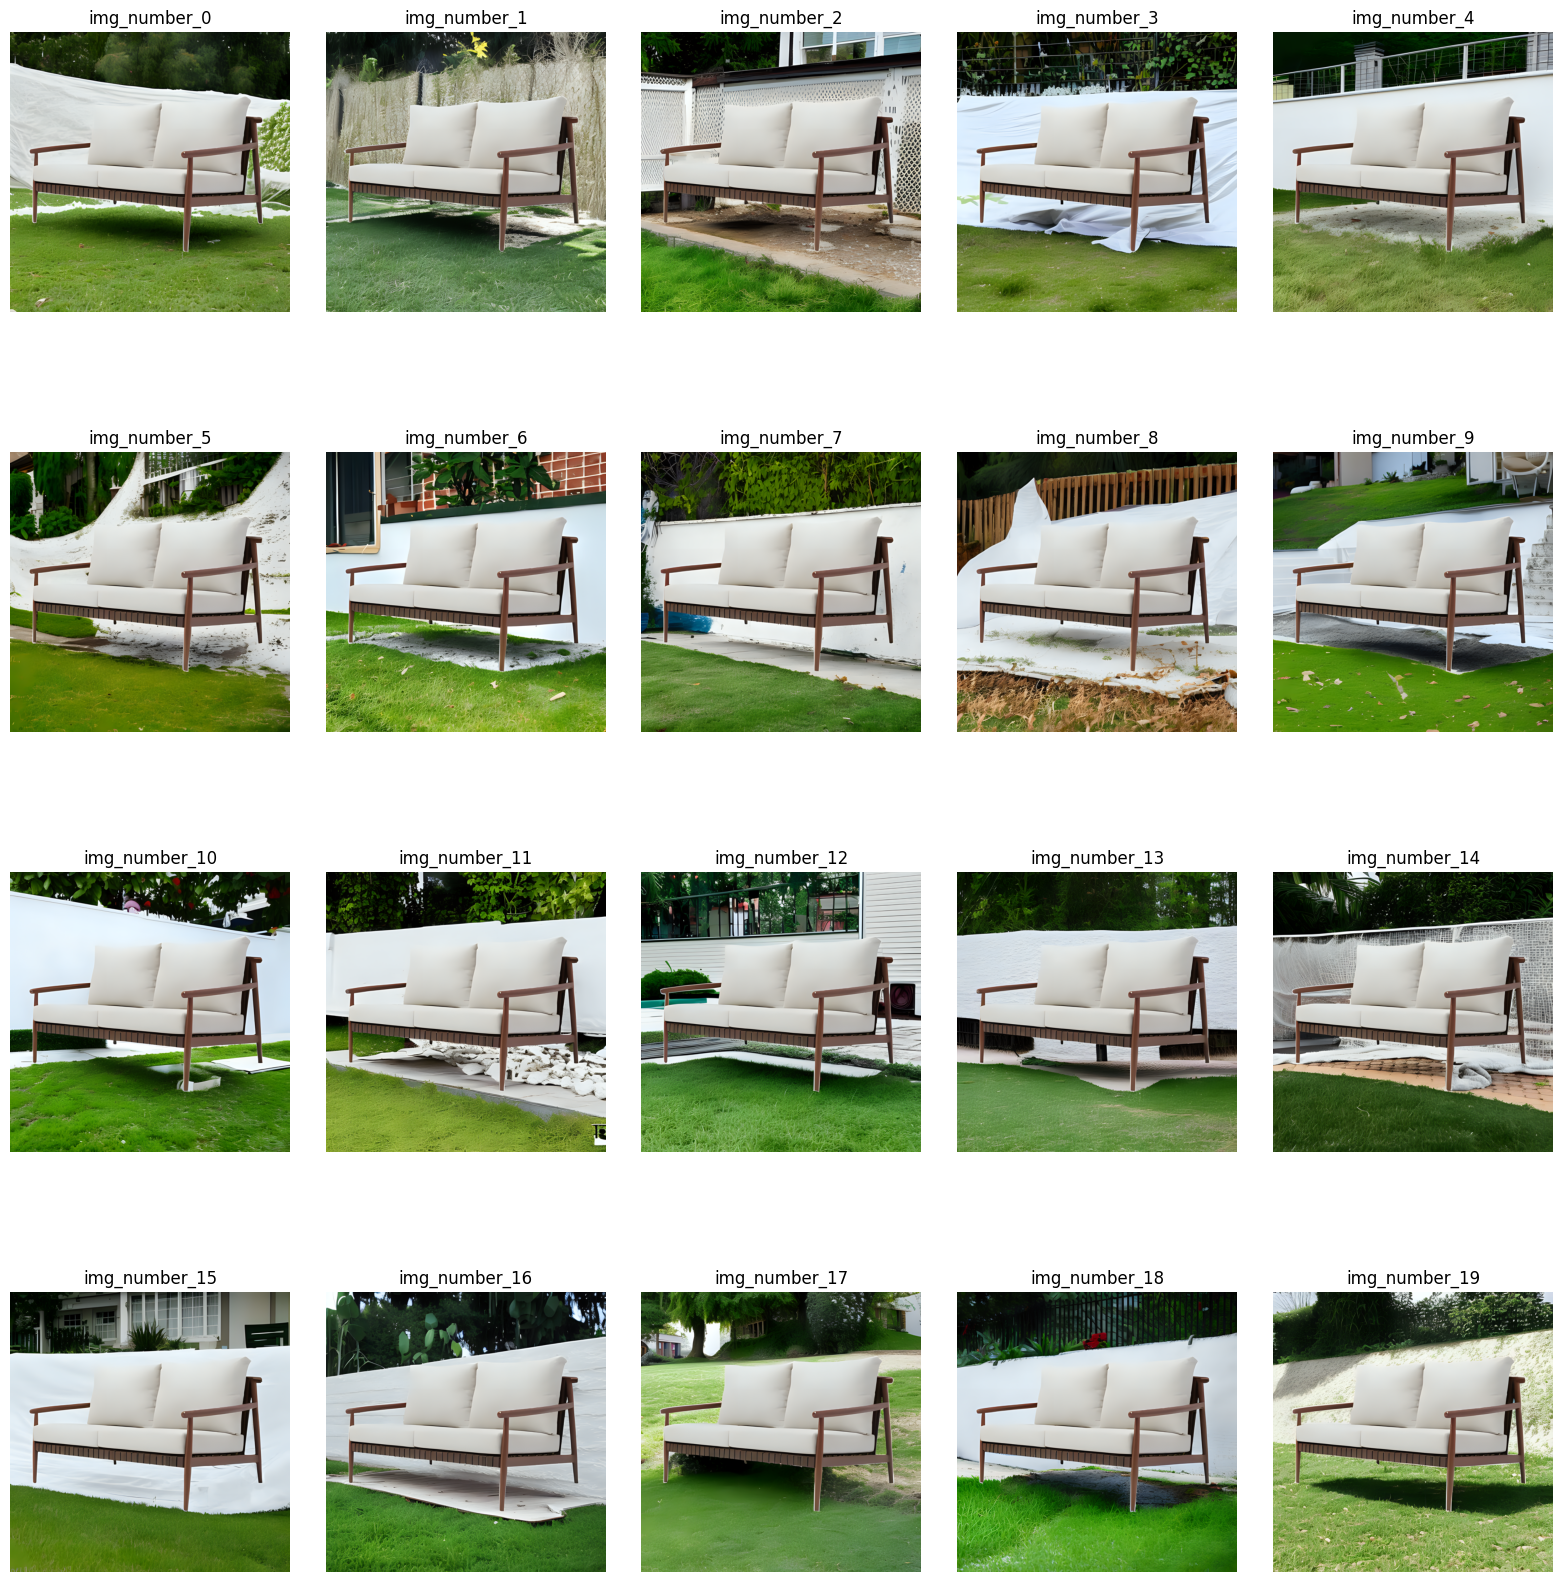

In [7]:
seed = 42
cond_scale = 1.0
mask = ImageOps.invert(fg_mask)

generator = torch.Generator(device='cuda').manual_seed(seed)


for loc_idx, location in enumerate(data[item_description["category"]]):
    prompt = f"{item_description['furniture']} {location}"
    loc_folder = os.path.join("results", str(loc_idx))
    shutil.rmtree(loc_folder, ignore_errors=True)
    os.makedirs(loc_folder, exist_ok=True) 
    
    with torch.autocast('cuda'):
        pipe_images = pipeline(
            prompt=prompt, 
            image=resized_img, mask_image=mask,
            control_image=mask, num_images_per_prompt=20,
            generator=generator, num_inference_steps=25,
            guess_mode=False,
            controlnet_conditioning_scale=cond_scale
        ).images

    result_images = []
    
    for idx, img in enumerate(tqdm(pipe_images)):
        sr_image = upscaler.predict(img)
        img_path = os.path.join(loc_folder, f"{idx + 1}.jpeg")
        sr_image.save(img_path, format="JPEG")
        result_images.append(sr_image)
    plot_path = os.path.join(loc_folder, "collage.png")
    make_plot(result_images, plot_path)
    

In [8]:
len(result_images)

20